In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format ='retina'

In [2]:
def read_data(result_dir = "sgd-grda_c0.001_mu0.501_eval_curve", data_name = 'te_nll'):
    data = np.load(result_dir + ".npz")
    return data['ts'], data[data_name]


In [3]:
import argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import seaborn as sns

SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

In [4]:
folders = [file for file in os.listdir() if not os.path.isfile(file)]
folders_all = []
for folder in folders:
    # if folder[0] != '.' and folder == 'result':
    if folder[0] != '.' and folder == 'result_cifar100_wrn':
        folders_all.append(folder)

In [5]:
matplotlib.rc('text', usetex=False)

matplotlib.rc('xtick.major', pad=12)
matplotlib.rc('ytick.major', pad=12)
matplotlib.rc('grid', linewidth=0)

class LogNormalize(colors.Normalize):

    def __init__(self, vmin=None, vmax=None, clip=None, log_alpha=None):
        self.log_alpha = log_alpha
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        log_v = np.ma.log(value - self.vmin)
        log_v = np.ma.maximum(log_v, self.log_alpha)
        return 0.9 * (log_v - self.log_alpha) / (np.log(self.vmax - self.vmin) - self.log_alpha)


def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)
nx = 0.7
light_jet = cmap_map(lambda x: (x+nx)/(1+nx), matplotlib.cm.jet)

def plane(axs_sub, grid, values, vmax=None, log_alpha=-5, N=7, cmap='jet_r', format_colorbar='%.1e'):
    cmap = plt.get_cmap(cmap)
    if vmax is None:
        clipped = values.copy()
    else:
        clipped = np.minimum(values, vmax)
    log_gamma = (np.log(clipped.max() - clipped.min()) - log_alpha) / N
    levels = clipped.min() + np.exp(log_alpha + log_gamma * np.arange(N + 1))
    levels[0] = clipped.min()
    levels[-1] = clipped.max()
    levels = np.concatenate((levels, [1e10]))
    norm = LogNormalize(clipped.min() - 1e-8, clipped.max() + 1e-8, log_alpha=log_alpha)
    # contour = axs_sub.contour(grid[:, :, 0], grid[:, :, 1], values, cmap=cmap, norm=norm,
    #                       linewidths=2.5,
    #                       zorder=1,
    #                       levels=levels)
    contourf = axs_sub.contourf(grid[:, :, 0], grid[:, :, 1], values, cmap=cmap, norm=norm,
                            levels=levels,
                            zorder=0,
                            alpha=0.8)
    colorbar = fig.colorbar(contourf, ax=axs_sub, format=format_colorbar, location='right')
    

    labels = list(colorbar.ax.get_yticklabels())
    # labels[-1].set_text(r'$>\,$' + labels[-2].get_text())
    colorbar.ax.set_yticklabels(labels)
    contour = None
    return contour, contourf, colorbar


In [6]:

from matplotlib import patches

In [7]:


import matplotlib.ticker as mticker
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.1e' % x))

def plot_plane_each_trloss(axs_sub, folder):
    file_read = np.load(folder + "/plane.npz")
    contour, contourf, colorbar = plane(
        axs_sub,
        file_read['grid'],
        file_read['tr_loss'],
        vmax=5.0,
        log_alpha=-5.0,
        N=20,
        cmap='Spectral',
        # cmap=light_jet,
        format_colorbar=mticker.FuncFormatter(g)
    )

    bend_coordinates = file_read['bend_coordinates']
    curve_coordinates = file_read['curve_coordinates']

    axs_sub.scatter(bend_coordinates[[0, 2], 0], bend_coordinates[[0, 2], 1], marker='o', c='w', s=80, zorder=2)
    axs_sub.annotate("gRDA", (bend_coordinates[0, 0]-6.5, bend_coordinates[0, 1]-1.), fontsize=13, fontweight='bold', c='w')
    axs_sub.annotate("SGD", (bend_coordinates[2, 0]-3.5, bend_coordinates[2, 1]-1.), fontsize=13, fontweight='bold', c='w')
    axs_sub.plot(curve_coordinates[:, 0], curve_coordinates[:, 1], linewidth=4, c='w', label='$w(t)$', zorder=4)

    axs_sub.margins(0.0)
    axs_sub.tick_params(axis='x', labelsize=14, bottom=False, top=False, labelbottom=False)
    axs_sub.tick_params(axis='y', labelsize=14, left=False, right=False, labelbottom=False)

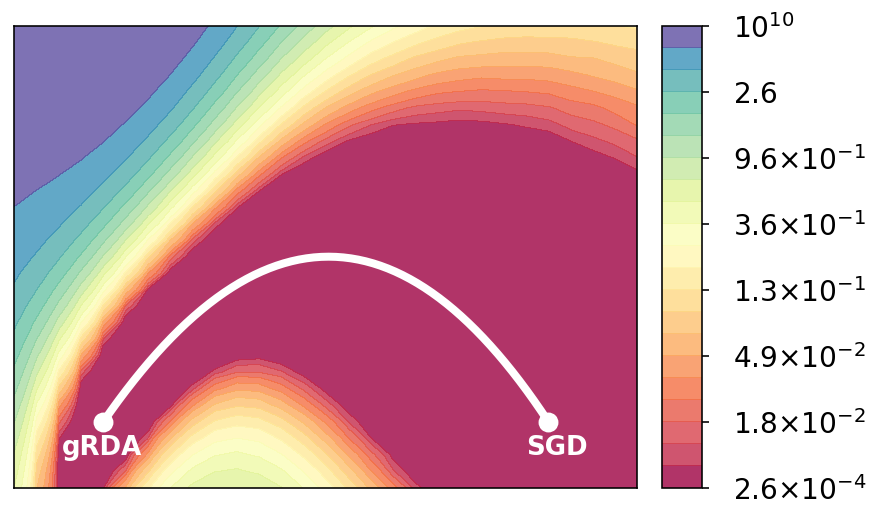

In [8]:

import matplotlib.ticker as mtick



fig, axs = plt.subplots(1, 1, constrained_layout=True)
fig.set_figheight(3.5)
fig.set_figwidth(6)

if len(folders_all) == 1:
    axs_sub = axs
    plt.setp( axs_sub.get_xticklabels(), visible=False)
    plt.setp( axs_sub.get_yticklabels(), visible=False)
    plot_plane_each_trloss(axs_sub, folders_all[0]) # mu0.6


plt.savefig('intro_cifar100_conn.pdf')